## Dependencies and imports

In [ ]:
! pip install --quiet transformers datasets jiwer pytokenizations matplotlib==3.5.2
# ! pip install matplotlib --upgrade

     |████████████████████████████████| 4.7 MB 7.1 MB/s 
     |████████████████████████████████| 365 kB 54.8 MB/s 
     |████████████████████████████████| 265 kB 54.0 MB/s 
     |████████████████████████████████| 11.2 MB 45.9 MB/s 
     |████████████████████████████████| 944 kB 53.8 MB/s 
     |████████████████████████████████| 6.6 MB 50.5 MB/s 
     |████████████████████████████████| 101 kB 12.6 MB/s 
     |████████████████████████████████| 596 kB 47.6 MB/s 
     |████████████████████████████████| 212 kB 9.7 MB/s 
     |████████████████████████████████| 115 kB 51.6 MB/s 
     |████████████████████████████████| 141 kB 41.5 MB/s 
     |████████████████████████████████| 127 kB 48.0 MB/s 
     |████████████████████████████████| 50 kB 4.9 MB/s 


In [ ]:
import os
import json
import torch
import datasets
import transformers
import tokenizations
import soundfile as sf
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np

from typing import *
from tqdm import tqdm
from pprint import pprint
from jiwer import wer, wil
from datasets import load_dataset
from transformers import AutoProcessor, AutoModelForCTC

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
ROOT_DIR = "/content/drive/My Drive/data/nlp/"

Mounted at /content/drive


## Models

In [ ]:
MODEL = "facebook/wav2vec2-large-960h-lv60-self"
# MODEL = "facebook/hubert-xlarge-ls960-ft"
MODEL_NAME = MODEL.split("/")[1]

LOCAL_MODEL_DUMP = f"{ROOT_DIR}speech2text/models/{MODEL_NAME}"

# load pretrained model
if not os.path.isdir(LOCAL_MODEL_DUMP):

    model = AutoModelForCTC.from_pretrained(MODEL).to("cuda" if torch.cuda.is_available() else "cpu")
    processor = AutoProcessor.from_pretrained(MODEL)
    model.save_pretrained(LOCAL_MODEL_DUMP)
    processor.save_pretrained(LOCAL_MODEL_DUMP)

else:

    model = AutoModelForCTC.from_pretrained(LOCAL_MODEL_DUMP).to("cuda" if torch.cuda.is_available() else "cpu")
    processor = AutoProcessor.from_pretrained(LOCAL_MODEL_DUMP)

## Datasets

In [ ]:
# load librispeech dataset

LOCAL_DATASET_DUMP = f"{ROOT_DIR}speech2text/datasets/librispeech_test_"

if not os.path.isdir(f"{LOCAL_DATASET_DUMP}clean") and not os.path.isdir(f"{LOCAL_DATASET_DUMP}other"):

    librispeech_test_clean = load_dataset("andreagasparini/librispeech_test_only", "clean", split="test")
    librispeech_test_other = load_dataset("andreagasparini/librispeech_test_only", "other", split="test")

    librispeech_test_clean.save_to_disk(f"{LOCAL_DATASET_DUMP}clean")
    librispeech_test_other.save_to_disk(f"{LOCAL_DATASET_DUMP}other")

else:

    librispeech_test_clean = datasets.Dataset.load_from_disk(f"{LOCAL_DATASET_DUMP}clean")
    librispeech_test_other = datasets.Dataset.load_from_disk(f"{LOCAL_DATASET_DUMP}other")

In [ ]:
def map_to_pred(batch):
    inputs = processor(batch["audio"]["array"], return_tensors="pt", padding="longest", sampling_rate=batch["audio"]["sampling_rate"])
    input_values = inputs.input_values.to("cuda" if torch.cuda.is_available() else "cpu")
    attention_mask = inputs.attention_mask.to("cuda" if torch.cuda.is_available() else "cpu")
    
    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    # TODO add [0] in README on HF Hub
    transcription = processor.batch_decode(predicted_ids)[0]
    batch["transcription"] = transcription
    return batch

In [ ]:
if os.path.isfile(f"{ROOT_DIR}speech2text/predictions/{MODEL_NAME}-test_other_predictions.json") and \
   os.path.isfile(f"{ROOT_DIR}speech2text/predictions/{MODEL_NAME}-test_clean_predictions.json"):

    with open(f"{ROOT_DIR}speech2text/predictions/{MODEL_NAME}-test_clean_predictions.json", "r") as f:
        result_test_clean = datasets.Dataset.from_dict(json.load(f))

    with open(f"{ROOT_DIR}speech2text/predictions/{MODEL_NAME}-test_other_predictions.json", "r") as f:
        result_test_other = datasets.Dataset.from_dict(json.load(f))
else:

    result_test_clean = librispeech_test_clean.map(map_to_pred, remove_columns=["audio", "file"])
    result_test_other = librispeech_test_other.map(map_to_pred, remove_columns=["audio", "file"])

    with open(f"{ROOT_DIR}speech2text/predictions/{MODEL_NAME}-test_clean_predictions.json", "w+") as f:
        json.dump(result_test_clean.to_dict(), f)

    with open(f"{ROOT_DIR}speech2text/predictions/{MODEL_NAME}-test_other_predictions.json", "w+") as f:
        json.dump(result_test_other.to_dict(), f)

  0%|          | 0/2620 [00:00<?, ?ex/s]

  0%|          | 0/2939 [00:00<?, ?ex/s]

In [ ]:
print("Test clean WER:", wer(result_test_clean["text"], result_test_clean["transcription"]))
print("Test other WER:", wer(result_test_other["text"], result_test_other["transcription"]))

print()

print("Test clean WIL:", wil(result_test_clean["text"], result_test_clean["transcription"]))
print("Test other WIL:", wil(result_test_other["text"], result_test_other["transcription"]))

# facebook/wav2vec2-large-960h-lv60-self
# Test clean WER: 0.018620663420572125
# Test other WER: 0.0388590642492788

# Test clean WIL: 0.03387835282705198
# Test other WIL: 0.07020261573151665


# TODO update scores and how to compute them in HF Hub (also tag for HF Speech Bench)
# facebook/hubert-large-ls960-ft
# Test clean WER: 0.02076993304930006
# Test other WER: 0.0422979194925778

# Test clean WIL: 0.037503731328818235
# Test other WIL: 0.07675745276505341

Test clean WER: 0.018620663420572125
Test other WER: 0.0388590642492788

Test clean WIL: 0.03387835282705198
Test other WIL: 0.07020261573151665


## Error analysis

In [ ]:
def get_errors(tokenized_text: List[str], tokenized_transcription: List[str], verbose: bool = False) -> List[Dict]:

    errors = list()

    a2b, b2a = tokenizations.get_alignments(tokenized_text, tokenized_transcription)

    for i in range(len(tokenized_text)):
        # deletion, segmentation or typo (1-0, 1-N or 1-1)
        if len(a2b[i]) != 1 or tokenized_transcription[a2b[i][0]] != tokenized_text[i]:

            matches = [(j, tokenized_transcription[j]) for j in a2b[i]]

            is_insertion = False
            for idx in range(len(matches)-1, -1, -1):
                match_token = matches[idx][1]

                # insertion aligned as segmentation
                if tokenized_text[i] == match_token:
                    is_insertion = True
                    matches.pop(idx)
                    errors.append({
                        "tokens": [],
                        "matches": matches
                    })

            if not is_insertion:
                errors.append({
                    "tokens": [(i, tokenized_text[i])],
                    "matches": matches
                })
    
    for i in range(len(tokenized_transcription)):
        # insertion (0-1)
        if len(b2a[i]) == 0:

            errors.append({
                "tokens": [],
                "matches": [(i, tokenized_transcription[i])]
            })

        # union (N-1)
        elif len(b2a[i]) > 1:

            # remove errors inserted as multiple typos or segmentations (1-1 or 1-N errors) instead of unions (N-1)
            # TODO we are ignoring N-N, e.g. [(0, 'THE'), (1, 'SNATCHER')] --> [(0, 'THES'), (1, 'NATCHER')]
            errors = [error for error in errors if len(error["tokens"]) == 0 or error["tokens"][0][0] not in b2a[i]]

            errors.append({
                "tokens": [(j, tokenized_text[j]) for j in b2a[i]],
                "matches": [(i, tokenized_transcription[i])]
            })

    if verbose:
        for error in errors:
            print(error["tokens"], end=" --> ")
            print(error["matches"])

    return errors

In [ ]:
def get_errors_dataset(results: List[Dict], transcriptions: List[str], filter_corrects: bool = True) -> List[Dict]:

    from nltk import WhitespaceTokenizer, TreebankWordTokenizer

    tokenizer = WhitespaceTokenizer()

    ds = list()

    for i, (text, transcription) in enumerate(zip(results["text"], transcriptions)):

        tokenized_text, tokenized_transcription = tokenizer.tokenize(text), tokenizer.tokenize(transcription)

        errors = get_errors(tokenized_text, tokenized_transcription)

        if not filter_corrects or len(errors) > 0:

            ds.append({
                "id": results["id"][i],
                "text": tokenized_text,
                "transcription": tokenized_transcription,
                "tokenizer": ".".join([WhitespaceTokenizer.__module__, WhitespaceTokenizer.__name__]),
                "errors": {
                    "silver": errors
                }
            })

    return ds

In [ ]:
def pop_errors(tokenized_text: List[str], tokenized_transcription: List[str], errors: List[Dict]) -> Tuple[List[str], List[str]]:

    remove_from_a, remove_from_b = set(), set()

    for error in errors:
        remove_from_a |= {x[0] for x in error["tokens"]}
        remove_from_b |= {x[0] for x in error["matches"]}
                           
    remove_from_a = sorted(list(remove_from_a), reverse=True)
    remove_from_b = sorted(list(remove_from_b), reverse=True)

    for i in remove_from_a:
        tokenized_text.pop(i)

    for i in remove_from_b:
        tokenized_transcription.pop(i)

    return tokenized_text, tokenized_transcription

In [ ]:
def get_label(sample):
    return "silver" if "gold" not in sample["errors"] else "gold"

### Print errors alignment

In [ ]:
def print_errors(texts: List[str], transcriptions: List[str]) -> None:
    from nltk import WhitespaceTokenizer, TreebankWordTokenizer

    tokenizer = WhitespaceTokenizer()

    results_no_errors = [tokenizer.tokenize(x) for x in texts]
    transcriptions_no_errors = [tokenizer.tokenize(x) for x in transcriptions]

    cnt = 0
    cnt_2 = 0
    pd = list()
    for i, (text, transcription) in enumerate(zip(texts, transcriptions)):
        if text != transcription:
            cnt += 1

            tokenized_text, tokenized_transcription = tokenizer.tokenize(text), tokenizer.tokenize(transcription)

            print(f"Error on sample #{i}:", end="\n\n")
            print(tokenizer.tokenize(text))
            print(tokenizer.tokenize(transcription), end="\n\n")

            errors = get_errors(tokenized_text, tokenized_transcription, verbose=True)

            pop_errors(results_no_errors[i], transcriptions_no_errors[i], errors)

            if results_no_errors[i] != transcriptions_no_errors[i]:
                cnt_2 += 1
                pd.append((i, results_no_errors[i], transcriptions_no_errors[i]))

            print()
            print(results_no_errors[i])
            print(transcriptions_no_errors[i])

            print()
            print("==" * 10, end="\n\n")

    print(f"Errors: {cnt}/{len(transcriptions)}", end="\n\n")

    print(f"Not correctly aligned: {cnt_2}", end="\n\n")
    from pprint import pprint
    for i, x, y in pd:
        print(f"#{i}")
        print(x)
        print(y)
        print()

In [ ]:
print_errors(result_test_clean["text"], transcriptions_clean)

Streaming output truncated to the last 5000 lines.

['THE', 'THRALLS', 'WERE', 'IN', 'A', 'GREAT', 'POT', 'OF', 'MEAT']
['THE', 'THRALLS', 'WERE', 'IN', 'A', 'GREAT', 'POT', 'OF', 'MEAT']


Error on sample #932:

['THEN', 'I', 'DRANK', 'HALF', 'OF', 'THE', 'HORNFUL', 'AND', 'SENT', 'THE', 'REST', 'ACROSS', 'THE', 'FIRE', 'TO', 'THE', 'FARMER', 'HE', 'TOOK', 'IT', 'AND', 'SMILED', 'SAYING']
['THEN', 'I', 'DRANK', 'HALF', 'OF', 'THE', 'HORNFULL', 'AND', 'SET', 'THE', 'REST', 'ACROSS', 'THE', 'FIRE', 'TO', 'THE', 'FARMER', 'HE', 'TOOK', 'IT', 'AND', 'SMILED', 'SAYING']

[(6, 'HORNFUL')] --> [(6, 'HORNFULL')]
[(8, 'SENT')] --> [(8, 'SET')]

['THEN', 'I', 'DRANK', 'HALF', 'OF', 'THE', 'AND', 'THE', 'REST', 'ACROSS', 'THE', 'FIRE', 'TO', 'THE', 'FARMER', 'HE', 'TOOK', 'IT', 'AND', 'SMILED', 'SAYING']
['THEN', 'I', 'DRANK', 'HALF', 'OF', 'THE', 'AND', 'THE', 'REST', 'ACROSS', 'THE', 'FIRE', 'TO', 'THE', 'FARMER', 'HE', 'TOOK', 'IT', 'AND', 'SMILED', 'SAYING']


Error on sample #935:

['HAKON'

In [ ]:
print_errors(result_test_other["text"], transcriptions_other)

Streaming output truncated to the last 5000 lines.

Error on sample #2046:

['NEXT', 'NED', 'CILLEY', 'WAS', 'RELIEVED', 'AT', 'THE', 'HELM', 'BY', 'ELBERT', 'JONES', 'WHO', 'TOOK', 'OVER', 'NED', 'WENT', 'ON', 'DOWN']
['NEXT', 'NED', 'SILLY', 'WAS', 'RELIEVED', 'AT', 'THE', 'HELM', 'BY', 'ALBERT', 'JONES', 'WHO', 'TOOK', 'OVER', 'NED', 'WENT', 'ON', 'DOWN']

[(2, 'CILLEY')] --> [(2, 'SILLY')]
[(9, 'ELBERT')] --> [(9, 'ALBERT')]

['NEXT', 'NED', 'WAS', 'RELIEVED', 'AT', 'THE', 'HELM', 'BY', 'JONES', 'WHO', 'TOOK', 'OVER', 'NED', 'WENT', 'ON', 'DOWN']
['NEXT', 'NED', 'WAS', 'RELIEVED', 'AT', 'THE', 'HELM', 'BY', 'JONES', 'WHO', 'TOOK', 'OVER', 'NED', 'WENT', 'ON', 'DOWN']


Error on sample #2047:

['IT', 'LOOKS', 'TO', 'ME', 'AS', 'IF', 'IT', 'COULD', 'HAVE', 'BEEN', 'ONE', 'OF', 'SEVERAL', 'PEOPLE', 'AND', "I'LL", 'BE', 'SWITCHED', 'IF', 'I', 'KNOW', 'WHO', "I'LL", 'KEEP', 'MY', 'EYES', 'OPEN']
['IT', 'LOOKS', 'TO', 'ME', 'AS', 'IF', 'IT', 'DHAVE', 'BEEN', 'ONE', 'OF', 'SEVERAL', 'PEOP

### Manually fix wrong error alignments

In [ ]:
print("==" * 50, end="\n\n")
print("Test (other) wrongly aligned errors:", end="\n\n")

error_other_ds = get_errors_dataset(result_test_other, transcriptions_other, filter_corrects=False)

for i, sample in enumerate(error_other_ds):
    
    text, transcription = sample["text"].copy(), sample["transcription"].copy()

    pop_errors(text, transcription, sample["errors"][get_label(sample)])

    if text != transcription:
        print(f"#{i} - ID: {sample['id']}")
        print(sample["errors"]["silver"])
        print(sample["text"])
        print(sample["transcription"])
        print()

error_other_ds[105]["errors"]["gold"] = [{'tokens': [(2, 'THE')], 'matches': [(2, 'THEM')]}, {'tokens': [(10, 'AND')], 'matches': []}]
error_other_ds[108]["errors"]["gold"] = [{'tokens': [(2, 'LADS')], 'matches': [(2, 'LAD')]}]
error_other_ds[208]["errors"]["gold"] = [{'tokens': [(3, 'THIRST')], 'matches': [(3, 'THOSE')]}, {'tokens': [(4, 'OR')], 'matches': [(4, 'STOOD')]}]
error_other_ds[222]["errors"]["gold"] = [{'tokens': [(3, 'TERRA')], 'matches': [(3, 'TERAS')]}, {'tokens': [(4, 'SINE')], 'matches': [(4, 'IN')]}]
# was aligned as segmentation and deletion instead as substitution 
error_other_ds[299]["errors"]["gold"] = [{'matches': [(5, 'AT')], 'tokens': [(5, 'ERE')]}, {'matches': [(9, 'ESCAPE')], 'tokens': [(9, 'SCAPED')]}]
error_other_ds[577]["errors"]["gold"] = [{'tokens': [(10, 'RESCUED')], 'matches': [(10, 'RESCUE')]}, {'tokens': [(18, 'MYRTILUS')], 'matches': [(18, 'MYRTILLUS')]}]
error_other_ds[613]["errors"]["gold"] = [{'tokens': [(29, 'OF')], 'matches': [(29, 'O')]}]
error_other_ds[692]["errors"]["gold"] = [{'tokens': [(12, 'MAKAN')], 'matches': [(11, 'MAKHAN')]}, {'tokens': [(10, 'ZAU'), (11, 'AL')], 'matches': [(10, 'ZAUAL')]}, {'tokens': [(23, 'SIRE')], 'matches': [(22, "SIRE'S")]}, {'tokens': [(24, 'SANS')], 'matches': [(23, 'SONS')]}]
error_other_ds[782]["errors"]["gold"] = [{'tokens': [(1, 'WOULD')], 'matches': [(1, 'DOULD')]}, {'tokens': [(13, 'WORRY')], 'matches': [(13, 'WERE')]}, {'tokens': [(14, 'HER')], 'matches': [(14, 'HURT')]}]
error_other_ds[1212]["errors"]["gold"] = [{'tokens': [(17, 'PO')], 'matches': [(17, 'POOR')]}, {'tokens': [(19, 'LIZABETH')], 'matches': [(19, 'ELIZABETH')]}]
error_other_ds[1162]["errors"]["gold"] = [{'tokens': [(5, 'THE')], 'matches': []}]
error_other_ds[1643]["errors"]["gold"] = [{'tokens': [(11, 'AT')], 'matches': [(11, 'A')]}, {'tokens': [(12, "JOCELYN'S")], 'matches': [(12, 'JOSCELYN')]}, {'tokens': [(13, 'ROCK')], 'matches': [(13, 'STROCK')]}]
error_other_ds[1731]["errors"]["gold"] = [{'tokens': [(11, 'VAUGIRARD')], 'matches': [(11, 'VAGERAS')]}, {'tokens': [(16, 'PERE')], 'matches': [(16, 'PERLA')]}, {'tokens': [(17, 'LACHAISE')], 'matches': [(17, 'CHAISE')]}]
error_other_ds[1789]["errors"]["gold"] = [{'tokens': [(2, 'UNS')], 'matches': [(2, 'UN')]}, {'tokens': [(9, 'OL')], 'matches': [(9, 'OLD')]}, {'tokens': [(18, 'HAVE')], 'matches': [(18, 'HAV')]}]
error_other_ds[1829]["errors"]["gold"] = [{'tokens': [(9, 'IRONICAL')], 'matches': [(9, 'IRONIC')]}]
error_other_ds[2016]["errors"]["gold"] = [{'tokens': [(7, 'WI')], 'matches': [(7, 'WITH')]}, {'tokens': [(16, 'FATHER')], 'matches': [(16, 'ATHER')]}]
error_other_ds[2052]["errors"]["gold"] = [{'tokens': [(1, 'FINNEY')], 'matches': [(1, 'FINNER')]}, {'tokens': [(11, 'OVERHEARD')], 'matches': [(11, 'HEARD')]}]
error_other_ds[2074]["errors"]["gold"] = [{'tokens': [(1, 'SHALL')], 'matches': [(1, 'SHOULD')]}, {'tokens': [(2, 'I')], 'matches': [(2, 'ALLI')]}]
error_other_ds[2076]["errors"]["gold"] = [{'tokens': [(4, "CAN'T")], 'matches': [(4, 'CATCH')]}, {'tokens': [(5, 'CHANGE')], 'matches': [(5, "JANE'S")]}]
# TODO 2114 deletion + insertion --> substitution
error_other_ds[2178]["errors"]["gold"] = [{'tokens': [(1, "AIN'T")], 'matches': [(1, 'ANT')]}, {'tokens': [(2, 'IT')], 'matches': [(2, 'AT')]}, {'tokens': [(10, 'DO')], 'matches': [(10, 'TO')]}, {'tokens': [(8, 'YER')], 'matches': [(8, 'YOU')]}, {'tokens': [(9, 'AUNT')], 'matches': [(9, "AREN'T")]}]
error_other_ds[2258]["errors"]["gold"] = [{'tokens': [(29, 'IN')], 'matches': [(29, 'ON')]}, {'tokens': [(20, 'WILD')], 'matches': [(20, 'WHITE')]}]
error_other_ds[2299]["errors"]["gold"] = [{'tokens': [(0, 'THE')], 'matches': [(0, 'THES')]}, {'tokens': [(1, 'SNATCHER')], 'matches': [(1, 'NATCHER')]}]
error_other_ds[2314]["errors"]["gold"] = [{'tokens': [(8, 'BYE')], 'matches': [(8, 'BY')]}]
error_other_ds[2348]["errors"]["gold"] = [{'tokens': [(36, 'PRISONER')], 'matches': [(36, 'PRISONERS')]}]
error_other_ds[2397]["errors"]["gold"] = [{'tokens': [(15, 'KENITES')], 'matches': [(15, 'KENNITES')]}, {'tokens': [(21, 'YAHWEH')], 'matches': [(21, 'AWAY')]}, {'tokens': [(22, 'OR')], 'matches': [(22, 'HOR')]}]
error_other_ds[2404]["errors"]["gold"] = [{'tokens': [(5, 'ANTOLIAN')], 'matches': [(5, 'ENTONIAN')]}, {'tokens': [(7, 'IN')], 'matches': [(7, 'OF')]}, {'tokens': [], 'matches': [(12, 'WILL')]}]
error_other_ds[2406]["errors"]["gold"] = [{'tokens': [(0, 'PROAS')], 'matches': [(0, 'PEROTS')]}, {'tokens': [(14, 'SEA')], 'matches': [(15, 'C')]}, {'tokens': [(16, 'FULL')], 'matches': [(17, 'FOUR')]}, {'tokens': [(29, 'ACTS')], 'matches': [(30, 'ACT')]}, {'tokens': [], 'matches': [(8, 'THE')]}]
error_other_ds[2414]["errors"]["gold"] = [{'tokens': [(5, 'TO')], 'matches': [(5, 'TOO')]}, {'tokens': [(6, 'OUR')], 'matches': [(6, 'HORD')]}, {'tokens': [(7, 'TWO')], 'matches': [(7, 'TOO')]}]
error_other_ds[2710]["errors"]["gold"] = [{'tokens': [(6, 'MINE')], 'matches': [(6, 'MIE')]}, {'tokens': [(8, 'MINE')], 'matches': [(8, 'MI')]}, {'tokens': [(13, 'THEIR')], 'matches': [(13, 'THEY')]}, {'tokens': [(14, 'LIKE')], 'matches': [(14, 'ALIKE')]}]
# was aligned as segmentation + deletion + insertion instead as substitution + insertion (different one)
error_other_ds[2780]["errors"]["gold"] = [{'tokens': [(8, 'ONE')], 'matches': [(8, 'A')]}, {'tokens': [], 'matches': [(10, 'AD')]}]
# TODO 2795 deletion + insertion --> substitution

with open(f"{ROOT_DIR}speech2text/{MODEL_NAME}-errors_other_full.json", "w+") as f:
    json.dump(error_other_ds, f, indent=4)

print("==" * 50, end="\n\n")
print("Test (clean) wrongly aligned errors:", end="\n\n")

error_clean_ds = get_errors_dataset(result_test_clean, transcriptions_clean, filter_corrects=False)

for i, sample in enumerate(error_clean_ds):
    
    text, transcription = sample["text"].copy(), sample["transcription"].copy()
    pop_errors(text, transcription, sample["errors"][get_label(sample)])

    if text != transcription:
        print(f"#{i} - ID: {sample['id']}")
        print(sample["errors"]["silver"])
        print(text)
        print(transcription)
        print(sample["text"])
        print(sample["transcription"])
        print()

error_clean_ds[27]["errors"]["gold"] = [{'tokens': [(4, 'IN')], 'matches': [(4, 'ON')]}, {'tokens': [(15, 'THAT')], 'matches': [(15, 'IT')]}]
error_clean_ds[739]["errors"]["gold"] = [{'tokens': [(4, 'GUESTS')], 'matches': [(4, 'GUEST')]}, {'tokens': [(20, 'TONIGHT')], 'matches': [(20, 'TO'), (21, 'NIGHT')]}, {'tokens': [(32, 'CREIGHTON')], 'matches': [(33, 'CRIHTON')]}, {'tokens': [(39, 'CREIGHTON')], 'matches': [(40, 'CRIHTON')]}]
error_clean_ds[747]["errors"]["gold"] = [{'tokens': [(1, "WE'RE")], 'matches': [(1, 'WE'), (2, "'RE")]}, {'tokens': [(3, 'ER')], 'matches': []}, {'tokens': [(5, 'WELCOMED')], 'matches': [(5, 'WELCOME')]}]
error_clean_ds[771]["errors"]["gold"] = [{'tokens': [(0, "DON'T")], 'matches': [(0, 'DO')]}, {'tokens': [(1, 'KNOW')], 'matches': [(1, 'NO')]}]
error_clean_ds[795]["errors"]["gold"] = [{'tokens': [(11, 'PAIN')], 'matches': [(11, 'PAINS')]}]
error_clean_ds[890]["errors"]["gold"] = [{'tokens': [(12, 'THE')], 'matches': []}]
error_clean_ds[949]["errors"]["gold"] = [{'tokens': [(18, 'SOMETIME')], 'matches': [(18, 'SOME'), (19, 'TIME')]}, {'tokens': [(8, 'SIF')], 'matches': [(8, 'SIFT')]}]
error_clean_ds[995]["errors"]["gold"] = [{'tokens': [(4, 'OFFICERS')], 'matches': [(4, 'OFFICER')]}]
# TODO 1008 deletion + insertion --> substitution
# TODO 1274 deletion + insertion --> substitution
error_clean_ds[1420]["errors"]["gold"] = [{'tokens': [(15, 'ANDERS')], 'matches': [(15, 'ANDER')]}]
error_clean_ds[1992]["errors"]["gold"] = [{'tokens': [(5, 'MILES')], 'matches': [(5, 'MYLES')]}, {'tokens': [(7, 'LAREN')], 'matches': [(7, 'CLAREN')]}]
error_clean_ds[2005]["errors"]["gold"] = [{'tokens': [(0, 'THIS')], 'matches': [(0, 'THI')]}]
# TODO 2279 deletion + insertion --> substitution
error_clean_ds[2292]["errors"]["gold"] = [{'tokens': [(38, 'TACK')], 'matches': [(38, 'TAK')]}, {'tokens': [(13, 'THE')], 'matches': [(13, 'THES')]}]
error_clean_ds[2308]["errors"]["gold"] = [{'tokens': [(0, 'MORNIN')], 'matches': [(0, 'MORNING')]}, {'tokens': [(3, 'YE')], 'matches': [(3, 'YOU')]}, {'tokens': [(8, 'YE')], 'matches': [(8, 'YOU')]}]
error_clean_ds[2312]["errors"]["gold"] = [{'tokens': [(2, 'SAID')], 'matches': [(2, 'SENT')]}, {'tokens': [(14, 'THIS')], 'matches': [(14, 'THE')]}, {'tokens': [(15, 'BILLYGOAT')], 'matches': [(15, 'SPILLY'), (16, 'GOAT')]}]
error_clean_ds[2575]["errors"]["gold"] = [{'tokens': [(4, "MILLION'D")], 'matches': [(4, 'MILLIONED')]}, {'tokens': [(15, 'TAN')], 'matches': [(15, "TAN'S")]}, {'tokens': [(20, "SHARP'ST")], 'matches': [(20, 'SHARPEST')]}, {'tokens': [(21, 'INTENTS')], 'matches': [(21, 'INTENTE')]}, {'tokens': [(51, "O'ER")], 'matches': [(51, 'OR')]}, {'tokens': [(52, 'INCERTAINTY')], 'matches': [(52, 'IN'), (53, 'CERTAINTY')]}]

with open(f"{ROOT_DIR}speech2text/{MODEL_NAME}-errors_clean_full.json", "w+") as f:
    json.dump(error_clean_ds, f, indent=4)

print("==" * 50)


Test (other) wrongly aligned errors:

#105 - ID: 7902-96594-0029
[{'tokens': [], 'matches': [(2, 'THEM')]}, {'tokens': [(2, 'THE'), (3, 'MEN')], 'matches': [(2, 'THEM')]}, {'tokens': [(9, 'SAID'), (10, 'AND')], 'matches': [(9, 'SAID')]}]
['PIPE', 'AWAY', 'THE', 'MEN', 'TO', 'THAT', 'BOAT', 'THERE', 'HE', 'SAID', 'AND', 'AS', 'THE', 'CREW', 'SPRANG', 'IN']
['PIPE', 'AWAY', 'THEM', 'MEN', 'TO', 'THAT', 'BOAT', 'THERE', 'HE', 'SAID', 'AS', 'THE', 'CREW', 'SPRANG', 'IN']

#108 - ID: 7902-96594-0032
[{'tokens': [(2, 'LADS'), (3, 'STEADY')], 'matches': [(3, 'STEADY')]}]
['STEADY', 'MY', 'LADS', 'STEADY', 'CRIED', 'THE', 'MASTER', 'KEEP', 'STROKE', 'AND', 'THEN', 'HE', 'BEGAN', 'TO', 'MAKE', 'PLANS', 'AS', 'TO', 'HIS', 'FIRST', 'PROCEEDINGS', 'ON', 'GETTING', 'ASHORE']
['STEADY', 'MY', 'LAD', 'STEADY', 'CRIED', 'THE', 'MASTER', 'KEEP', 'STROKE', 'AND', 'THEN', 'HE', 'BEGAN', 'TO', 'MAKE', 'PLANS', 'AS', 'TO', 'HIS', 'FIRST', 'PROCEEDINGS', 'ON', 'GETTING', 'ASHORE']

#208 - ID: 4198-12259-00

### Word-level errors classification

- (1-1) Substitution: character-level errors only
- (0-1) Insertion: a new token is added
- (1-0) Deletion: one token is missing
- (1-N) Segmentation: one token generates 2 or more tokens
- (N-1) Union: two or more tokens are merged into one

*Segmentation and Union can also have typos at character-level

In [ ]:
def classify_errors(errors_dataset: List[Dict]) -> Tuple[Dict[str, List[Dict]], Dict[str, int]]:

    wordlevel_errors = {
        "substitutions": list(),
        "insertions": list(),
        "deletions": list(),
        "segmentations": list(),
        "unions": list()
    }

    for sample in errors_dataset:
        errors = sample["errors"][get_label(sample)]
        if len(errors) > 0:

            for error in errors:

                error = error.copy()
                error["sample_id"] = sample["id"]
                
                tokens, matches = error["tokens"], error["matches"]

                if len(tokens) == 0:
                    wordlevel_errors["insertions"] += [error]
                elif len(tokens) == 1:
                    if len(matches) == 0:
                        wordlevel_errors["deletions"] += [error]
                    elif len(matches) == 1:
                        wordlevel_errors["substitutions"] += [error]                
                    elif len(matches) >= 2:
                        wordlevel_errors["segmentations"] += [error]
                elif len(tokens) >= 2:
                    wordlevel_errors["unions"] += [error]

    return wordlevel_errors, {k: len(v) for k, v in wordlevel_errors.items()}

Total test (other) errors: 1848
Total test (clean) errors: 869



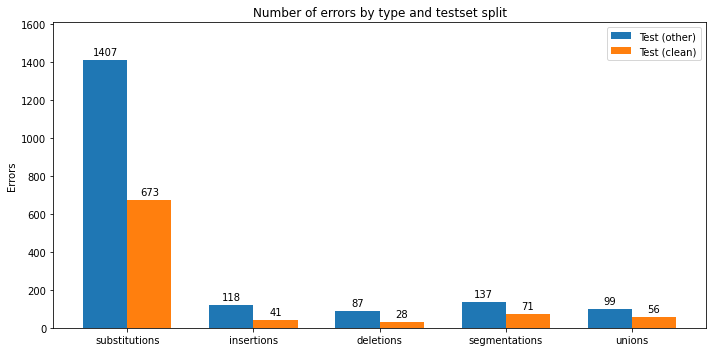

In [ ]:
wordlevel_errors_other, wordlevel_errors_cnt_other = classify_errors(error_other_ds)

print(f"Total test (other) errors: {sum(wordlevel_errors_cnt_other.values())}")

wordlevel_errors_clean, wordlevel_errors_cnt_clean = classify_errors(error_clean_ds)

print(f"Total test (clean) errors: {sum(wordlevel_errors_cnt_clean.values())}", end="\n\n")

labels = list(wordlevel_errors_other.keys())

x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 5))

rects1 = ax.bar(x - width/2, list(wordlevel_errors_cnt_other.values()), width, label='Test (other)')
rects2 = ax.bar(x + width/2, list(wordlevel_errors_cnt_clean.values()), width, label='Test (clean)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Errors')
ax.set_ylim([0, max(list(wordlevel_errors_cnt_other.values()) + list(wordlevel_errors_cnt_clean.values())) + 200])
ax.set_title('Number of errors by type and testset split')
ax.set_xticks(x, labels=labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

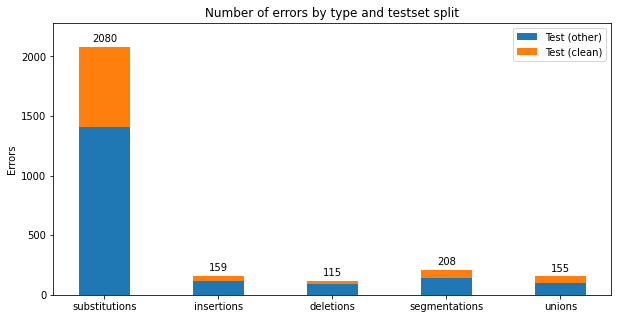

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

width = 0.45

ax.bar(labels, list(wordlevel_errors_cnt_other.values()), width, label='Test (other)')
rects = ax.bar(labels, list(wordlevel_errors_cnt_clean.values()), width, bottom=list(wordlevel_errors_cnt_other.values()), label='Test (clean)')

ax.set_ylabel('Errors')
ax.set_ylim([0, max(wordlevel_errors_cnt_other.values()) + max(wordlevel_errors_cnt_clean.values()) + 200])
ax.set_title('Number of errors by type and testset split')
ax.legend()

ax.bar_label(rects, padding=3)

plt.show()

### Lexical-semantic analysis

#### Contractions and compound words splits

Analyse whether the union/segmentation errors are caused by simple
- Contractions
- Compound words splits

In [ ]:
# TODO PR in contractions package for lowercase matching and multi-candidates support

contractions = { 
    "ain't": ["am not", "are not", "is not", "has not", "have not"],
    "aren't": ["are not", "am not"],
    "can't": ["cannot"],
    "can't've": ["cannot have"],
    "'cause": ["because"],
    "could've": ["could have"],
    "couldn't": ["could not"],
    "couldn't've": ["could not have"],
    "didn't": ["did not"],
    "doesn't": ["does not"],
    "don't": ["do not"],
    "hadn't": ["had not"],
    "hadn't've": ["had not have"],
    "hasn't": ["has not"],
    "haven't": ["have not"],
    "he'd": ["he had", "he would"],
    "he'd've": ["he would have"],
    "he'll": ["he shall", "he will"],
    "he'll've": ["he shall have", "he will have"],
    "he's": ["he has", "he is"],
    "here's": ["here is"],
    "how'd": ["how did"],
    "how'd'y": ["how do you"],
    "how'll": ["how will"],
    "how's": ["how has", "how is", "how does"],
    "i'd": ["i had", "i would"],
    "i'd've": ["i would have"],
    "i'll": ["i shall", "i will"],
    "i'll've": ["i shall have", "i will have"],
    "i'm": ["i am"],
    "i've": ["i have"],
    "isn't": ["is not"],
    "it'd": ["it had", "it would"],
    "it'd've": ["it would have"],
    "it'll": ["it shall", "it will"],
    "it'll've": ["it shall have", "it will have"],
    "it's": ["it has", "it is"],
    "let's": ["let us"],
    "ma'am": ["madam"],
    "mayn't": ["may not"],
    "might've": ["might have"],
    "mightn't": ["might not"],
    "mightn't've": ["might not have"],
    "must've": ["must have"],
    "mustn't": ["must not"],
    "mustn't've": ["must not have"],
    "needn't": ["need not"],
    "needn't've": ["need not have"],
    "o'clock": ["of the clock"],
    "on't": ["on it"],                              # NEW
    "oughtn't": ["ought not"],
    "oughtn't've": ["ought not have"],
    "shan't": ["shall not"],
    "sha'n't": ["shall not"],
    "shan't've": ["shall not have"],
    "she'd": ["she had", "she would"],
    "she'd've": ["she would have"],
    "she'll": ["she shall", "she will"],
    "she'll've": ["she shall have", "she will have"],
    "she's": ["she has", "she is"],
    "should've": ["should have"],
    "shouldn't": ["should not"],
    "shouldn't've": ["should not have"],
    "so've": ["so have"],
    "so's": ["so as", "so is"],
    "that'd": ["that would", "that had"],
    "that'd've": ["that would have"],
    "that's": ["that has", "that is"],
    "there'd": ["there had", "there would"],
    "there'd've": ["there would have"],
    "there's": ["there has", "there is"],
    "they'd": ["they had", "they would"],
    "they'd've": ["they would have"],
    "they'll": ["they shall", "they will"],
    "they'll've": ["they shall have", "they will have"],
    "they're": ["they are"],
    "they've": ["they have"],
    "to've": ["to have"],
    "wasn't": ["was not"],
    "we'd": ["we had", "we would"],
    "we'd've": ["we would have"],
    "we'll": ["we will"],
    "we'll've": ["we will have"],
    "we're": ["we are"],
    "we've": ["we have"],
    "weren't": ["were not"],
    "what'll": ["what shall", "what will"],
    "what'll've": ["what shall have", "what will have"],
    "what're": ["what are"],
    "what's": ["what has", "what is"],
    "what've": ["what have"],
    "when's": ["when has", "when is"],
    "when've": ["when have"],
    "where'd": ["where did"],
    "where's": ["where has", "where is"],
    "where've": ["where have"],
    "who'll": ["who shall", "who will"],
    "who'll've": ["who shall have", "who will have"],
    "who's": ["who has", "who is"],
    "who've": ["who have"],
    "why's": ["why has", "why is"],
    "why've": ["why have"],
    "will've": ["will have"],
    "won't": ["will not"],
    "won't've": ["will not have"],
    "would've": ["would have"],
    "wouldn't": ["would not"],
    "wouldn't've": ["would not have"],
    "y'all": ["you all"],
    "y'all'd": ["you all would"],
    "y'all'd've": ["you all would have"],
    "y'all're": ["you all are"],
    "y'all've": ["you all have"],
    "you'd": ["you had", "you would"],
    "you'd've": ["you would have"],
    "you'll": ["you shall", "you will"],
    "you'll've": ["you shall have", "you will have"],
    "you're": ["you are"],
    "you've": ["you have"]
}

In [ ]:
segmentation_splits_cnt = 0
segmentation_contractions_cnt = 0

for error in wordlevel_errors_other["segmentations"] + wordlevel_errors_clean["segmentations"]:
    token = error["tokens"][0][1] 
    token_lowered = token.lower()
    matches = [x[1] for x in error["matches"]]
    merged_matches = "".join(matches)
    merged_matches_spaced_lowered = " ".join(matches).lower()

    if token == merged_matches:
        segmentation_splits_cnt += 1
    elif "O'" in token and token.replace("O'", "OF") == merged_matches:
        segmentation_contractions_cnt += 1
    elif token_lowered in contractions:
        decontractions = contractions[token_lowered]
        for decontraction in decontractions:
            if decontraction == merged_matches_spaced_lowered:
                segmentation_contractions_cnt += 1
    else:
        # print(token, merged_matches, error["matches"], error["sample_id"])
        ...

print()
print(f"Contractions: {segmentation_contractions_cnt}/{len(wordlevel_errors_other['segmentations']) +  len(wordlevel_errors_clean['segmentations'])}")
print(f"Splits: {segmentation_splits_cnt}/{len(wordlevel_errors_other['segmentations']) +  len(wordlevel_errors_clean['segmentations'])}")


Contractions: 29/208
Splits: 102/208


Errors aligned as segmentations but where insertions

e.g. sample #127 of test-other has
{'tokens': [(22, 'FULL')], 'matches': [(22, 'OF'), (23, 'FULL')]}

but should instead have {'tokens': [], 'matches': [(22, 'OF')]}

In [ ]:
## Included in the get_errors function
for i, sample in enumerate(error_other_ds + error_clean_ds):
    for error in sample["errors"][get_label(sample)]:
        if len(error["tokens"]) == 1 and error["tokens"][0][1] in [x[1] for x in error["matches"]]:
            # error["matches"] = [x for x in error["matches"] if x[1] != error["tokens"][0][1]]
            # error["tokens"] = []
            print(i)
            print(sample["errors"])
            print(sample["text"])
            print(sample["transcription"])
            print()

In [ ]:
union_splits_cnt = 0
union_contractions_cnt = 0

for error in wordlevel_errors_other["unions"] + wordlevel_errors_clean["unions"]:
    tokens = [x[1] for x in error["tokens"]]
    merged_tokens = "".join(tokens)
    merged_tokens_spaced_lowered = " ".join(tokens).lower()
    match = error["matches"][0][1] 
    match_lowered = match.lower()

    if merged_tokens == match:
        union_splits_cnt += 1
    elif "O'" in match and match.replace("O'", "OF") == merged_tokens:
        union_contractions_cnt += 1
    elif match_lowered in contractions:
        decontractions = contractions[match_lowered]
        for decontraction in decontractions:
            if decontraction == merged_tokens_spaced_lowered:
                union_contractions_cnt += 1
    else:
        # print(merged_tokens, match, error["tokens"], error["sample_id"])
        ...

print()
print(f"Contractions: {union_contractions_cnt}/{len(wordlevel_errors_other['unions']) +  len(wordlevel_errors_clean['unions'])}")
print(f"Splits: {union_splits_cnt}/{len(wordlevel_errors_other['unions']) +  len(wordlevel_errors_clean['unions'])}")


Contractions: 13/155
Splits: 69/155


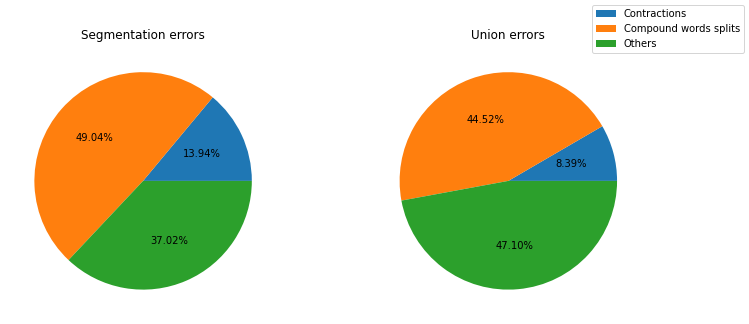

In [ ]:
pie_labels = [""] * 3
labels = ["Contractions", "Compound words splits", "Others"]

frac = lambda x, y, z: x / (y +  z) * 100
_fracs = lambda x, y: [x, y, 100-x-y]
autopct = "%.2f%%"

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

fracs = _fracs(frac(segmentation_contractions_cnt, len(wordlevel_errors_other["segmentations"]), len(wordlevel_errors_clean["segmentations"])),
               frac(segmentation_splits_cnt, len(wordlevel_errors_other["segmentations"]), len(wordlevel_errors_clean["segmentations"])))
axs[0].set_title("Segmentation errors")
patches, texts, autotexts = axs[0].pie(fracs, labels=pie_labels,
                                       autopct=autopct,
                                       shadow=False)

fracs = _fracs(frac(union_contractions_cnt, len(wordlevel_errors_other["unions"]), len(wordlevel_errors_clean["unions"])),
               frac(union_splits_cnt, len(wordlevel_errors_other["unions"]), len(wordlevel_errors_clean["unions"])))
axs[1].set_title("Union errors")
patches, texts, autotexts = axs[1].pie(fracs, labels=pie_labels,
                                       autopct=autopct,
                                       shadow=False)

fig.legend(patches, labels)

plt.show()

#### Slang usage

In [ ]:
slangs = {
    "'aight": "alright",
    "abt": "about",
    "acct": "account",
    "altho": "although",
    "asap": "as soon as possible",
    "avg": "average",
    "b4": "before",
    "bc": "because",
    "bday": "birthday",
    "btw": "by the way",
    "'bout": "about",
    "bout": "about",
    "convo": "conversation",
    "cya": "see ya",
    "diff": "different",
    "dunno": "do not know",
    "g'day": "good day",
    "gimme": "give me",
    "gonna": "going to",
    "gotta": "got to",
    "howdy": "how do you do",
    "idk": "i do not know",
    "ima": "i am going to",
    "imma": "i am going to",
    "innit": "is it not",
    "iunno": "i do not know",
    "kk": "okay",
    "lemme": "let me",
    "msg": "message",
    "nvm": "nevermind",
    "o": "of",                  # NEW
    "o'": "of",                 # NEW
    "ofc": "of course",
    "ppl": "people",
    "prolly": "probably",
    "pymnt": "payment",
    "r ": "are",
    "rlly": "really",
    "rly": "really",
    "rn": "right now",
    "spk": "spoke",
    "tbh": "to be honest",
    "tho": "though",
    "thx": "thanks",
    "tlked": "talked",
    "tmmw": "tomorrow",
    "tmr": "tomorrow",
    "tmrw": "tomorrow",
    "u": "you",
    "ur": "you are",
    "wanna": "want to",
    "woulda": "would have"
}

In [ ]:
slangs_cnt = 0

for error in wordlevel_errors_other["substitutions"] + wordlevel_errors_clean["substitutions"]:

    token = error["tokens"][0][1] 
    match = error["matches"][0][1] 

    if token.lower() in slangs:
        deslanged = slangs[token.lower()]
        if deslanged == match.lower():
            slangs_cnt += 1
    elif match.lower() in slangs:
        deslanged = slangs[match.lower()]
        if deslanged == token.lower():
            slangs_cnt += 1

print(f"Slangs: {slangs_cnt}/{len(wordlevel_errors_other['substitutions']) +  len(wordlevel_errors_clean['substitutions'])}")

Slangs: 13/2080


#### Stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
substitution_stopwords_cnt = 0

for error in wordlevel_errors_other["substitutions"] + wordlevel_errors_clean["substitutions"]:

    token = error["tokens"][0][1] 
    match = error["matches"][0][1] 

    if token.lower() in stopwords_set or match.lower() in stopwords_set:
        substitution_stopwords_cnt += 1

print(f"Stopwords in substitution errors: {substitution_stopwords_cnt}/{len(wordlevel_errors_other['substitutions']) +  len(wordlevel_errors_clean['substitutions'])}")

Stopwords in substitution errors: 415/2080


In [ ]:
insertion_stopwords_cnt = 0

for error in wordlevel_errors_other["insertions"] + wordlevel_errors_clean["insertions"]:

    match = error["matches"][0][1] 

    if match.lower() in stopwords_set:
        insertion_stopwords_cnt += 1
        
print(f"Stopwords in insertion errors: {insertion_stopwords_cnt}/{len(wordlevel_errors_other['insertions']) +  len(wordlevel_errors_clean['insertions'])}")

Stopwords in insertion errors: 146/159


In [ ]:
deletion_stopwords_cnt = 0

for error in wordlevel_errors_other["deletions"] + wordlevel_errors_clean["deletions"]:

    token = error["tokens"][0][1] 

    if token.lower() in stopwords_set:
        deletion_stopwords_cnt += 1

print(f"Stopwords in deletion errors: {deletion_stopwords_cnt}/{len(wordlevel_errors_other['deletions']) +  len(wordlevel_errors_clean['deletions'])}")

Stopwords in deletion errors: 108/115


In [ ]:
union_stopwords_cnt = 0

for error in wordlevel_errors_other["unions"] + wordlevel_errors_clean["unions"]:

    tokens = [err[1] for err in error["tokens"]]
    match = error["matches"][0][1]

    if all([token.lower() in stopwords_set for token in tokens]) or match.lower() in stopwords_set:
        union_stopwords_cnt += 1

print(f"Stopwords in union errors: {union_stopwords_cnt}/{len(wordlevel_errors_other['unions']) +  len(wordlevel_errors_clean['unions'])}")

Stopwords in union errors: 27/155


In [ ]:
segmentation_stopwords_cnt = 0

for error in wordlevel_errors_other["segmentations"] + wordlevel_errors_clean["segmentations"]:

    token = error["tokens"][0][1] 
    matches = [err[1] for err in error["matches"]]

    if all([match.lower() in stopwords_set for match in matches]) or token.lower() in stopwords_set:
        segmentation_stopwords_cnt += 1
        
print(f"Stopwords in segmentation errors: {segmentation_stopwords_cnt}/{len(wordlevel_errors_other['segmentations']) +  len(wordlevel_errors_clean['segmentations'])}")

Stopwords in segmentation errors: 38/208


In [ ]:
frac = lambda x, y, z: x / (y +  z) * 100
_fracs = lambda x: [x, 100-x]

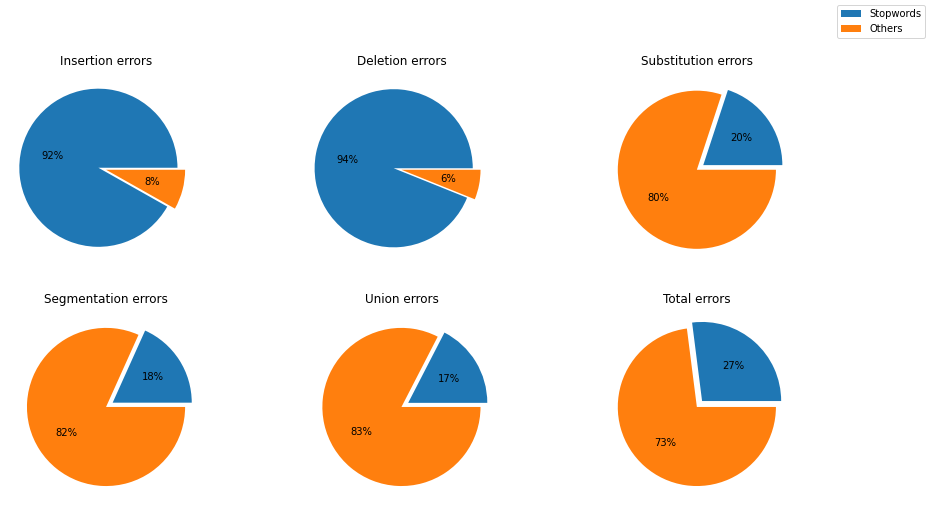

In [ ]:
labels = ["", ""]
autopct = "%.0f%%"

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

fracs = _fracs(frac(insertion_stopwords_cnt, len(wordlevel_errors_other["insertions"]), len(wordlevel_errors_clean["insertions"])))
axs[0, 0].set_title("Insertion errors")
patches, texts, autotexts = axs[0, 0].pie(fracs, labels=labels,
                                          autopct=autopct,
                                          shadow=False,
                                          explode=(0.1, 0))

fracs = _fracs(frac(deletion_stopwords_cnt, len(wordlevel_errors_other["deletions"]), len(wordlevel_errors_clean["deletions"])))
axs[0, 1].set_title("Deletion errors")
patches, texts, autotexts = axs[0, 1].pie(fracs, labels=labels,
                                          autopct=autopct,
                                          shadow=False,
                                          explode=(0.1, 0))

fracs = _fracs(frac(segmentation_stopwords_cnt, len(wordlevel_errors_other["segmentations"]), len(wordlevel_errors_clean["segmentations"])))
axs[1, 0].set_title("Segmentation errors")
patches, texts, autotexts = axs[1, 0].pie(fracs, labels=labels,
                                          autopct=autopct,
                                          shadow=False,
                                          explode=(0.1, 0))

fracs = _fracs(frac(union_stopwords_cnt, len(wordlevel_errors_other["unions"]), len(wordlevel_errors_clean["unions"])))
axs[1, 1].set_title("Union errors")
patches, texts, autotexts = axs[1, 1].pie(fracs, labels=labels,
                                          autopct=autopct,
                                          shadow=False,
                                          explode=(0.1, 0))

fracs = _fracs(frac(substitution_stopwords_cnt, len(wordlevel_errors_other["substitutions"]), len(wordlevel_errors_clean["substitutions"])))
axs[0, 2].set_title("Substitution errors")
patches, texts, autotexts = axs[0, 2].pie(fracs, labels=labels,
                                          autopct=autopct,
                                          shadow=False,
                                          explode=(0.1, 0))

stopwords_cnt = segmentation_stopwords_cnt + union_stopwords_cnt + substitution_stopwords_cnt + insertion_stopwords_cnt + deletion_stopwords_cnt
fracs = _fracs(frac(stopwords_cnt, sum(wordlevel_errors_cnt_other.values()), sum(wordlevel_errors_cnt_clean.values())))
axs[1, 2].set_title("Total errors")
patches, texts, autotexts = axs[1, 2].pie(fracs, labels=labels,
                                          autopct=autopct,
                                          shadow=False,
                                          explode=(0.1, 0))

fig.legend(patches, ["Stopwords", "Others"])

plt.show()

#### WSD stuff

##### Grammar errors

In [ ]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
  
# tokenizer = AutoTokenizer.from_pretrained("prithivida/grammar_error_correcter_v1")
# model = AutoModelForSeq2SeqLM.from_pretrained("prithivida/grammar_error_correcter_v1")

# phrases = {"transcriptions": list(), "texts": list()}
# for sample in error_other_ds + error_clean_ds:
#     if len(sample["errors"][get_label(sample)]) > 0:
#         phrases["transcriptions"].append(" ".join(sample["transcription"]))
#         phrases["texts"].append(" ".join(sample["text"]))

# corrections = list()

# batch_size = 2
# for i in tqdm(range(0, len(phrases["transcriptions"]), batch_size)):
#     batch = phrases["transcriptions"][i:i+batch_size]

#     # Tokenize text
#     tokenized_phrases = tokenizer(phrases["transcriptions"], return_tensors='pt', padding=True)

#     # Perform corrections and decode the output
#     model_out = model.generate(**tokenized_phrases)
#     corrections += tokenizer.batch_decode(model_out, skip_special_tokens=True)

# # Print correction
# for i in range(len(corrections)):
#   original, transcription, correction = phrases["texts"][i], phrases["transcription"][i], corrections[i]
#   print(f'[Phrase] {original}')
#   print(f'[Transc] {transcription}')
#   print(f'[Correc] {correction}')
#   print('~'*100)

In [ ]:
! pip install happytransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 2.0 MB/s 
     |████████████████████████████████| 1.2 MB 8.9 MB/s 


In [ ]:
# from happytransformer import HappyTextToText, TTSettings

# happy_tt = HappyTextToText("T5", "vennify/t5-base-grammar-correction")

# args = TTSettings(num_beams=5, min_length=1)

# phrases = {"transcriptions": list(), "texts": list()}
# for sample in error_other_ds + error_clean_ds:
#     if len(sample["errors"][get_label(sample)]) > 0:
#         phrases["transcriptions"].append(" ".join(sample["transcription"]))
#         phrases["texts"].append(" ".join(sample["text"]))

# corrections = list()

# for i in tqdm(range(len(phrases["transcriptions"]))):
#     sample = phrases["transcriptions"][i]

#     # Add the prefix "grammar: " before each input 
#     result = happy_tt.generate_text(f"grammar: {sample}", args=args)

#     corrections.append(result.text)

In [ ]:
# # Print correction
# for i in range(len(corrections)):
#     original, transcription, correction = phrases["texts"][i], phrases["transcriptions"][i], corrections[i]
#     print(f'[Phrase] {original}')
#     print(f'[Transc] {transcription}')
#     print(f'[Correc] {correction}')
#     print('~'*100)

In [ ]:
# phrases["corrections"] = corrections

# with open(f"{ROOT_DIR}speech2text/grammar-corrections.json", "w+") as f:
#     json.dump(phrases, f, indent=4)

##### Known words

In [ ]:
import nltk
from nltk.corpus import wordnet, words

nltk.download("wordnet")
nltk.download("words")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
substitution_known_words_errors = list()
substitution_unknown_words_errors = list()

errors = wordlevel_errors_other["substitutions"] + wordlevel_errors_clean["substitutions"]
for i in tqdm(range(len(errors))):

    error = errors[i]

    token = error["tokens"][0][1]
    match = error["matches"][0][1]

    if match.lower() in contractions:
        tokenized_decontraction = [x for x in contractions[match.lower()]][0].split(" ")
        if all([x in words.words() or len(wordnet.synsets(x)) > 0 for x in tokenized_decontraction]):
            substitution_known_words_errors.append(error)
    elif len(wordnet.synsets(match.lower())) == 0 and match.lower() not in words.words():
        substitution_unknown_words_errors.append(error)
    else:
        substitution_known_words_errors.append(error)

print()
print()
print(f"Unkown words transcriptions in substitution errors: {len(substitution_unknown_words_errors)}/{len(wordlevel_errors_other['substitutions']) +  len(wordlevel_errors_clean['substitutions'])}")

100%|██████████| 2080/2080 [01:32<00:00, 22.57it/s]



Unkown words transcriptions in substitution errors: 802/2080


In [ ]:
unknown_frac = frac(len(substitution_unknown_words_errors), len(wordlevel_errors_other['substitutions']), len(wordlevel_errors_clean['substitutions']))
known_frac = frac(len(substitution_known_words_errors), len(wordlevel_errors_other['substitutions']), len(wordlevel_errors_clean['substitutions']))
f"unknown: {round(unknown_frac, 2)}%", \
f"known: {round(known_frac, 2)}%"

('unknown: 38.56%', 'known: 61.44%')

In [ ]:
def get_lemmas(keyword: str):
    lemmas=list()
    for synset in wordnet.synsets(keyword):
        for lemma in synset.lemmas():
            lemmas.append(lemma)
    return lemmas

In [ ]:
synonyms = list()
hyponyms = list()
hypernyms = list()
lemmatizations = list()

senses = list()

stopwords_errors = list()
tickwise_errors = list()
slangs = list()

unknown_in_known_match = list()

# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()

for error in substitution_known_words_errors:

    token = error["tokens"][0][1]
    match = error["matches"][0][1]
    
    # print(token, match)

    a = False

    # includes plural, verb tenses and some american/british inflections
    for synset in get_lemmas(token):
        if synset in get_lemmas(match):
            synonyms.append(error)
            # print(token, match)
            a = True
            break

    if a: continue

    if "'" in match or "'" in token:
        # slangs ("rank'd" instead of "ranked")
        if (token.replace("'", "E") == match or match.replace("'", "E") == token or
            token.replace("'", "G") == match or match.replace("'", "G") == token):
            # print(token, match)
            tickwise_errors.append(error)
            continue
        # possessive ('s),  and other tick-wise contractions
        elif (token.replace("'", "") == match or match.replace("'", "") == token or
              token.replace("'S", "") == match or match.replace("'S", "") == token):
            # print(token, match)
            tickwise_errors.append(error)
            continue
        # elif match.lower() in contractions or token.lower() in contractions:
        #     print(token, match)
        #     ...

    if match.lower() in slangs and slangs[match.lower()] == token.lower() or token.lower() in slangs and slangs[token.lower()] == match.lower():
        # print(token, match)
        slangs.append(error)
        continue
    
    if len(wordnet.synsets(match)) > 0 and len(wordnet.synsets(token)) > 0:
        senses.append(error)
        # print(token, match)
        continue

    if match.lower() in stopwords_set or token.lower() in stopwords_set:
        stopwords_errors.append(error)
        continue

    if len(wordnet.synsets(token.lower())) == 0 and token.lower() not in words.words():
        unknown_in_known_match.append(error)

    # for synset in wordnet.synsets(token):
    #     for synset2 in wordnet.synsets(match):
    #         if synset in synset2.hyponyms():
    #             hypernyms.append(error)
    #             break

    # for synset in wordnet.synsets(token):
    #     for synset2 in wordnet.synsets(match):
    #         if synset in synset2.hypernyms():
    #             hyponyms.append(error)
    #             break

    # # all catched by wordnet
    # if lemmatizer.lemmatize(token.lower()) == lemmatizer.lemmatize(match.lower()):
    #     lemmatizations.append(error)

    # if len(wordnet.synsets(token.lower())) == 0 and token.lower() not in words.words():
    #     print(token)

len(synonyms), len(senses), len(tickwise_errors), len(stopwords_errors), len(slangs), len(unknown_in_known_match), len(lemmatizations), len(hypernyms), len(hyponyms), len(substitution_known_words_errors)

(347, 351, 34, 276, 0, 209, 0, 0, 0, 1278)

In [ ]:
f"{round(len(synonyms) / len(substitution_known_words_errors) * 100, 2)}% of the known matches ({round(known_frac, 2)}%) are either plural, verb tenses or american/british inflections"

'27.15% of the known matches (61.44%) are either plural, verb tenses or american/british inflections'

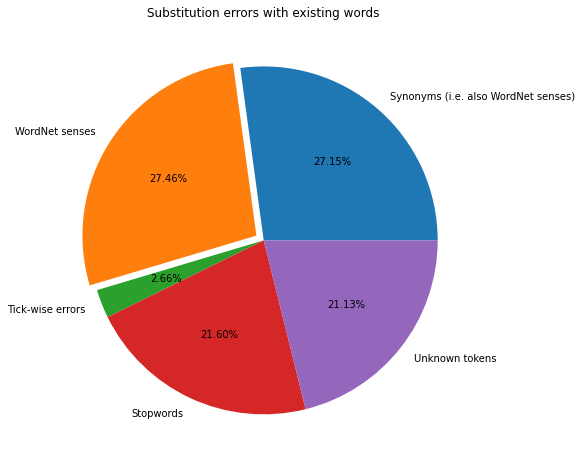

In [ ]:
labels = ["Synonyms (i.e. also WordNet senses)", "WordNet senses", "Tick-wise errors", "Stopwords", "Unknown tokens"]

frac = lambda x, y: x / y * 100
autopct = "%.2f%%"

fig, axs = plt.subplots(figsize=(8, 8))

fracs = [frac(len(synonyms), len(substitution_known_words_errors)),
         frac(len(senses), len(substitution_known_words_errors)),
         frac(len(tickwise_errors), len(substitution_known_words_errors)),
         frac(len(stopwords_errors), len(substitution_known_words_errors)),
         frac(len(substitution_known_words_errors) - (len(synonyms) + len(senses) + len(tickwise_errors) + len(stopwords_errors)), len(substitution_known_words_errors))]

axs.set_title("Substitution errors with existing words")
patches, texts, autotexts = axs.pie(fracs, labels=labels,
                                    autopct=autopct,
                                    shadow=False,
                                    explode=(0, 0.05, 0, 0, 0))

plt.show()

### TODOs
 - British vs American english ?
    - https://stackoverflow.com/questions/42329766/python-nlp-british-english-vs-american-english

- Homophones checker/corrector ?
    - https://www.google.com/search?q=nltk+homophones&rlz=1C1VDKB_itIT959IT959&oq=nltk+homophones&aqs=chrome..69i57j33i160l3.2342j0j7&sourceid=chrome&ie=UTF-8
    - https://github.com/kjanjua26/Pyphones
    - https://groups.google.com/g/nltk-users/c/-98sQvKFEwY

## Candidate generation


In [ ]:
subtitution_error_samples_wordnet_no_synonyms = list()

for sample in error_clean_ds + error_other_ds:
    
    errors = sample["errors"][get_label(sample)]

    if len(errors) > 0:

        for error in errors:

            tokens = error["tokens"]
            matches = error["matches"]

            if len(tokens) == 1 and len(matches) == 1:

                token = tokens[0][1]
                match = matches[0][1]

                # a = False

                # # includes plural, verb tenses and some american/british inflections
                # for synset in get_lemmas(token):
                #     if synset in get_lemmas(match):
                #         synonyms.append(error)
                #         # print(token, match)
                #         a = True
                #         break
                
                # if a: continue
                
                # if len(wordnet.synsets(match)) > 0 and len(wordnet.synsets(token)) > 0:
                samp = sample.copy()
                samp["errors"][get_label(sample)] = error
                subtitution_error_samples_wordnet_no_synonyms.append(samp)

### Masked language modelling

May there be biases from the previous context of the read sentence since LibriSpeech is build from reading of books, i.e. one sentence is usually related to the following one and therefore a single one may not be enough to infer a masked token.

- https://huggingface.co/blog/wav2vec2-with-ngram

In [ ]:
from transformers import pipeline
MLM_MODEL_NAME = "roberta-base" # "bert-base-uncased" | "roberta-base"
unmasker = pipeline("fill-mask", model=MLM_MODEL_NAME)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
mlm_fixs = list()

for i in tqdm(range(len(subtitution_error_samples_wordnet_no_synonyms))):

    sample = subtitution_error_samples_wordnet_no_synonyms[i]

    transcription = sample["transcription"]
    # print(transcription)
    masked_transcription = transcription.copy()
    masked_transcription[sample["errors"][get_label(sample)]["matches"][0][0]] = "<mask>"
    # print(masked_transcription)
    masked_transcription_str = " ".join(masked_transcription)

    for unmasked_option in unmasker(masked_transcription_str):
        if unmasked_option["sequence"].split(" ") == sample["text"]:
            # print(sample["text"])
            # print(sample["transcription"])
            # print(unmasked_option["sequence"])
            mlm_fixs.append({"sample": sample, "fix": unmasked_option["sequence"]})
            break

len(mlm_fixs)

100%|██████████| 2080/2080 [09:25<00:00,  3.68it/s]


71

In [ ]:
len(subtitution_error_samples_wordnet_no_synonyms)

2080

### TODO Character candidates w/ lower scores from the model

In [ ]:
# when negotiating with your union do you make sure employees have a choice between new benefits and their cents per hour cost in wages

# when negotiating with your union do you make sure employees have a choice between new benefits and their cents pay our costing wages